# Reproduction of FACS results using segmentation and colocalization of the images

This script is meant to analyse 2D confocal images from Schumacher 2023 figures 4G and H

Import packages, load segmentation model and define input and output paths

In [1]:
import tilesegment.tools.tools as tools
import tilesegment.tools.tiling as tiling
import matplotlib.pyplot as plt

from embdevtools import get_file_embcode, read_img_with_resolution, CellTracking, load_CellTracking, save_4Dstack
from embdevtools.celltrack.core.tools.tools import get_outlines_masks_labels
import numpy as np


### LOAD STARDIST MODEL ###
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

### PATH TO YOU DATA FOLDER AND TO YOUR SAVING FOLDER ###
path_data='/home/pablo/Desktop/PhD/projects/Data/belas/2D/Sina/activin/crops/movies/'
path_save='/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/'


2023-11-23 11:07:04.212539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 11:07:05.768175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-11-23 11:07:07.323726: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Define an activin quantity and load images. Activin concentration must be on the format like this `100ng` or `6.25ng` in order to be correctly read.

In [2]:
concentration = "50ng"

### GET FULL FILE NAME AND FILE CODE ###
file, embcode, files = get_file_embcode(path_data, "_"+concentration, allow_file_fragment=True, returnfiles=True)

### LOAD HYPERSTACKS ###
IMGS, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=0)
IMG = IMGS[0,0]

IMGS_cer1, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=1)
IMG_cer1 = IMGS_cer1[0,0]

IMGS_oct4, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=2)
IMG_oct4 = IMGS_oct4[0,0]

IMGS_otx2, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=3)
IMG_otx2 = IMGS_otx2[0,0]

try: 
    xyresdif = np.abs(np.abs(xyres[0]) - np.abs(xyres[1]))
    print("xyres dif =", xyresdif)
    xyres = np.mean(xyres)
except: 
    pass

print(xyres)

0.36044530855199747


Define tiling information: 

* `Ts` = Tile size
* `D` = Image size after squaring the image and making int multiple of Ts
* `O` = Overlap based on cell nuclei. For example 3 times the mean cell nuclei as observed using the remove debrie script
* `Tso` = Tile size with overlap
* `DO` = total image size with overlap
* `n` = number of tiles in a row or column
* `N` = total number of tiles

In [3]:
### TILING ###

# Tile size
Ts = 1024
# Size with overlap
O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation
tile_info = tiling.generate_tiling_info(IMG, Ts, O)

Generate padded image

In [4]:
# Create squared and padded image
IMG_padded, pad_info = tiling.pad_image_and_square_array(IMG, tile_info)

Define a threshold diameter for debris removal

In [5]:
diam_th = 5 #microns

Loop over tiles rows (`i`) and columns (`j`). Once segmentation is completed, cells falling into the overlaping area must be removed. That what `mins` and `maxs` are used for. Also, `offset` must be computed so that `center`, `outline` and `mask` have indexes corresponding to the whole image, not the tile. 

In [6]:
centers, outlines, masks, diameters = tiling.tile_segment(IMG_padded, 
                                                model, 
                                                tile_info, 
                                                pad_info, 
                                                xyres, 
                                                diam_th, 
                                                verbose=True)
### SEGMENTATION COMPLETED ###

1/1 [==============================] - 1s 1s/step
tiles left = 48
1/1 [==============================] - 1s 618ms/step
tiles left = 47
1/1 [==============================] - 1s 583ms/step
tiles left = 46
1/1 [==============================] - 1s 646ms/step
tiles left = 45
1/1 [==============================] - 1s 571ms/step
tiles left = 44
1/1 [==============================] - 1s 632ms/step
tiles left = 43
1/1 [==============================] - 1s 581ms/step
tiles left = 42
1/1 [==============================] - 1s 546ms/step
tiles left = 41
1/1 [==============================] - 1s 544ms/step
tiles left = 40
1/1 [==============================] - 1s 573ms/step
tiles left = 39
1/1 [==============================] - 1s 536ms/step
tiles left = 38
1/1 [==============================] - 1s 524ms/step
tiles left = 37
1/1 [==============================] - 1s 531ms/step
tiles left = 36
1/1 [==============================] - 1s 528ms/step
tiles left = 35
1/1 [==============================] 

Once the segmentation is completed, we can compute colocalization of the different markers with the segmented masks. We can compute the sum ot the mean within a mask. I trust more the results using mean as it removes information about cell size. 

In [7]:
### COLOCALIZATION AND DENSITY PLOTS ###

cer1 = []
oct4 = []
otx2 = []
for mask in masks:
    mask[mask < 0] = 0
    mask[:,0][mask[:,0]>=IMG.shape[0]] = IMG.shape[0]-1
    mask[:,1][mask[:,1]>=IMG.shape[1]] = IMG.shape[1]-1


    cer1.append(np.mean(IMG_cer1[mask[:,0], mask[:,1]]))
    oct4.append(np.mean(IMG_oct4[mask[:,0], mask[:,1]]))
    otx2.append(np.mean(IMG_otx2[mask[:,0], mask[:,1]]))


Once we have the values for the fluorescence per cell we can show some cells as examples of what to expect for each of the cases

In [8]:
### PLOT 3 CELL MARKERS AND MASK ###
import random 
x = ['cer1', 'otx2', 'oct4']
r = 20


c1 = random.randint(0, len(centers)-1)
c1 = 18746
center = np.rint(centers[c1]).astype("int32")
mask = masks[c1]
outline = outlines[c1]
outline = tools.increase_point_resolution(outline, 100)
IMG_mask = np.zeros_like(IMG)
IMG_mask[mask[:,0], mask[:,1]] = 1


fig ,ax = plt.subplots(2,6, figsize=(25,8), gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios': [1,1]}, dpi=600)
# fig.suptitle("activin = %s" %concentration)
ax[0,0].imshow(IMG, vmin=0, vmax=255)
ax[0,0].set_title("hoechst", fontsize=15)
ax[0,0].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,0].set_xlim(center[1]-r,center[1]+r)
ax[0,0].set_ylim( center[0]-r,center[0]+r)
ax[0,0].grid(False)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

ax[0,1].imshow(IMG_mask, vmin=0, vmax=1)
ax[0,1].set_title("mask", fontsize=15)
ax[0,1].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,1].set_xlim(center[1]-r,center[1]+r)
ax[0,1].set_ylim( center[0]-r,center[0]+r)
ax[0,1].grid(False)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

ax[0,2].imshow(IMG_cer1, vmin=0, vmax=255)
ax[0,2].set_title("cer1", fontsize=15)
ax[0,2].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,2].set_xlim(center[1]-r,center[1]+r)
ax[0,2].set_ylim( center[0]-r,center[0]+r)
ax[0,2].grid(False)
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])

ax[0,3].imshow(IMG_otx2, vmin=0, vmax=255)
ax[0,3].set_title("otx2", fontsize=15)
ax[0,3].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,3].set_xlim(center[1]-r,center[1]+r)
ax[0,3].set_ylim( center[0]-r,center[0]+r)
ax[0,3].grid(False)
ax[0,3].set_xticks([])
ax[0,3].set_yticks([])

ax[0,4].imshow(IMG_oct4, vmin=0, vmax=255)
ax[0,4].set_title("oct4", fontsize=15)
ax[0,4].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,4].set_xlim(center[1]-r,center[1]+r)
ax[0,4].set_ylim( center[0]-r,center[0]+r)
ax[0,4].grid(False)
ax[0,4].set_xticks([])
ax[0,4].set_yticks([])

y1 = [cer1[c1], otx2[c1], oct4[c1]]

ax[0,5].bar(x, y1, color=["yellow", "magenta", "blue"])
ax[0,5].set_title("mean intensity within mask", fontsize=15)
ax[0,5].set_xticklabels(x, fontsize=12)

c2 = random.randint(0, len(centers)-1)
c2 = 13116
r = 20
center = np.rint(centers[c2]).astype("int32")
mask = masks[c2]
outline = outlines[c2]
outline = tools.increase_point_resolution(outline, 100)
IMG_mask = np.zeros_like(IMG)
IMG_mask[mask[:,0], mask[:,1]] = 1

ax[1,0].imshow(IMG, vmin=0, vmax=255)
ax[1,0].grid(False)
ax[1,0].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,0].set_xlim(center[1]-r,center[1]+r)
ax[1,0].set_ylim( center[0]-r,center[0]+r)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,1].imshow(IMG_mask, vmin=0, vmax=1)
ax[1,1].grid(False)
ax[1,1].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,1].set_xlim(center[1]-r,center[1]+r)
ax[1,1].set_ylim( center[0]-r,center[0]+r)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

ax[1,2].imshow(IMG_cer1, vmin=0, vmax=255)
ax[1,2].grid(False)
ax[1,2].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,2].set_xlim(center[1]-r,center[1]+r)
ax[1,2].set_ylim( center[0]-r,center[0]+r)
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])

ax[1,3].imshow(IMG_otx2, vmin=0, vmax=255)
ax[1,3].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,3].set_xlim(center[1]-r,center[1]+r)
ax[1,3].set_ylim( center[0]-r,center[0]+r)
ax[1,3].grid(False)
ax[1,3].set_xticks([])
ax[1,3].set_yticks([])

ax[1,4].imshow(IMG_oct4, vmin=0, vmax=255)
ax[1,4].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,4].set_xlim(center[1]-r,center[1]+r)
ax[1,4].set_ylim( center[0]-r,center[0]+r)
ax[1,4].grid(False)
ax[1,4].set_xticks([])
ax[1,4].set_yticks([])

y2 = [cer1[c2], otx2[c2], oct4[c2]]
ax[1,5].bar(x, y2, color=["yellow", "magenta", "blue"])
ax[1,5].set_xticklabels(x, fontsize=12)

max_yaxis = np.max([np.max(y1),np.max(y2)])
ax[0,5].set_ylim(0, max_yaxis*1.1)
ax[1,5].set_ylim(0, max_yaxis*1.1)

plt.tight_layout()


plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/coloc%s.png" %concentration, format='png')
plt.show()

Cer 1 threshold definition as 1% of positive cells on the 0ng activin case

In [9]:
concentration = "0ng"

### GET FULL FILE NAME AND FILE CODE ###
file, embcode, files = get_file_embcode(path_data, "_"+concentration, allow_file_fragment=True, returnfiles=True)

### LOAD HYPERSTACKS ###
IMGS, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=0)
IMG = IMGS[0,0]

IMGS_cer1, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=1)
IMG_cer1 = IMGS_cer1[0,0]

IMGS_oct4, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=2)
IMG_oct4 = IMGS_oct4[0,0]

IMGS_otx2, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=3)
IMG_otx2 = IMGS_otx2[0,0]

try: 
    xyresdif = np.abs(np.abs(xyres[0]) - np.abs(xyres[1]))
    print("xyres dif =", xyresdif)
    xyres = np.mean(xyres)
except: 
    pass

### TILING ###

# Tile size
Ts = 1024
# Size with overlap
O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation
tile_info = tiling.generate_tiling_info(IMG, Ts, O)

IMG_padded, pad_info = tiling.pad_image_and_square_array(IMG, tile_info)

centers, outlines, masks, diameters = tiling.tile_segment(IMG_padded, 
                                                model, 
                                                tile_info, 
                                                pad_info, 
                                                xyres, 
                                                5, 
                                                verbose=True)

cer1 = []
oct4 = []
otx2 = []
for mask in masks:
    mask[mask < 0] = 0
    mask[:,0][mask[:,0]>=IMG.shape[0]] = IMG.shape[0]-1
    mask[:,1][mask[:,1]>=IMG.shape[1]] = IMG.shape[1]-1
    cer1.append(np.mean(IMG_cer1[mask[:,0], mask[:,1]]))
    oct4.append(np.mean(IMG_oct4[mask[:,0], mask[:,1]]))
    otx2.append(np.mean(IMG_otx2[mask[:,0], mask[:,1]]))

from scipy.stats import gaussian_kde

# Calculate the point density
otx2cer1 = np.vstack([np.log(otx2),np.log(cer1)])
z_otx2cer1 = gaussian_kde(otx2cer1)(otx2cer1)

cer1_sorted = np.sort(cer1)
top_idxs = np.rint(len(cer1_sorted)*0.01).astype('int32')
cer1_top1 = cer1_sorted[-top_idxs:]


cer1_th_0 = np.mean(cer1_top1)
print("cer1 threshold =", cer1_th_0)

xyres dif = 1.2992077363938037e-07
1/1 [==============================] - 1s 506ms/step
tiles left = 48
1/1 [==============================] - 1s 515ms/step
tiles left = 47
1/1 [==============================] - 1s 527ms/step
tiles left = 46
1/1 [==============================] - 1s 520ms/step
tiles left = 45
1/1 [==============================] - 1s 522ms/step
tiles left = 44
1/1 [==============================] - 1s 520ms/step
tiles left = 43
1/1 [==============================] - 1s 520ms/step
tiles left = 42
1/1 [==============================] - 1s 523ms/step
tiles left = 41
1/1 [==============================] - 1s 533ms/step
tiles left = 40
1/1 [==============================] - 1s 525ms/step
tiles left = 39
1/1 [==============================] - 1s 525ms/step
tiles left = 38
1/1 [==============================] - 1s 520ms/step
tiles left = 37
1/1 [==============================] - 1s 509ms/step
tiles left = 36
1/1 [==============================] - 1s 518ms/step
tiles left = 35

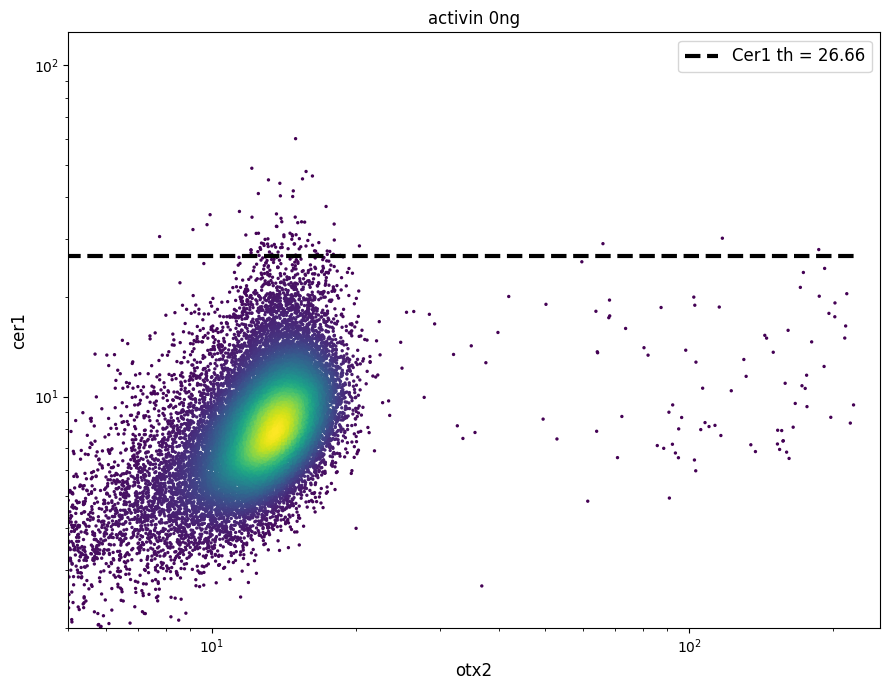

In [10]:

fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(otx2, cer1, c=z_otx2cer1, s=2)
# plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("otx2", fontsize=12)
ax.set_ylabel("cer1", fontsize=12)
ax.set_xlim(5, 10**2.4)
ax.set_ylim(2, 10**2.1)
ax.set_title("activin "+concentration)
x = np.linspace(min(otx2), max(otx2), 100)
y = np.ones(len(x)) * cer1_th_0
ax.plot(x, y, c='k', ls='--', lw=3, label="Cer1 th = {:0.2f}".format(cer1_th))
plt.tight_layout()
plt.legend(loc='upper right', fontsize=12)
plt.savefig(path_save+"otx2-cer1_cer1th_activin-"+concentration+".png")
plt.show()

To compute the thresholds of OTX2 we ran the segmentation for all Activin conditions and then find local minima in the OTX2 distributions.

In [11]:
concentrations = ["0ng", "6.25ng", "12.5ng", "25ng", "50ng", "100ng", "200ng"]
CER1 = []
OTX2 = []
OCT4 = []

for concentration in concentrations:
    print(concentration)
    ### GET FULL FILE NAME AND FILE CODE ###
    file, embcode, files = get_file_embcode(path_data, "_"+concentration, allow_file_fragment=True, returnfiles=True)

    ### LOAD HYPERSTACKS ###
    IMGS, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=0)
    IMG = IMGS[0,0]

    IMGS_cer1, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=1)
    IMG_cer1 = IMGS_cer1[0,0]

    IMGS_oct4, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=2)
    IMG_oct4 = IMGS_oct4[0,0]

    IMGS_otx2, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=3)
    IMG_otx2 = IMGS_otx2[0,0]

    try: 
        xyresdif = np.abs(np.abs(xyres[0]) - np.abs(xyres[1]))
        print("xyres dif =", xyresdif)
        xyres = np.mean(xyres)
    except: 
        pass

    ### TILING ###

    # Tile size
    Ts = 1024
    # Size with overlap
    O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation
    tile_info = tiling.generate_tiling_info(IMG, Ts, O)

    IMG_padded, pad_info = tiling.pad_image_and_square_array(IMG, tile_info)

    centers, outlines, masks, diameters = tiling.tile_segment(IMG_padded, 
                                                    model, 
                                                    tile_info, 
                                                    pad_info, 
                                                    xyres, 
                                                    5, 
                                                    verbose=True)

    cer1 = []
    oct4 = []
    otx2 = []
    for mask in masks:
        mask[mask < 0] = 0
        mask[:,0][mask[:,0]>=IMG.shape[0]] = IMG.shape[0]-1
        mask[:,1][mask[:,1]>=IMG.shape[1]] = IMG.shape[1]-1
        cer1.append(np.mean(IMG_cer1[mask[:,0], mask[:,1]]))
        oct4.append(np.mean(IMG_oct4[mask[:,0], mask[:,1]]))
        otx2.append(np.mean(IMG_otx2[mask[:,0], mask[:,1]]))
    
    CER1.append(cer1)
    OTX2.append(otx2)
    OCT4.append(oct4)

0ng
xyres dif = 1.2992077363938037e-07
1/1 [==============================] - 1s 533ms/step
tiles left = 48
1/1 [==============================] - 1s 516ms/step
tiles left = 47
1/1 [==============================] - 1s 520ms/step
tiles left = 46
1/1 [==============================] - 1s 521ms/step
tiles left = 45
1/1 [==============================] - 1s 523ms/step
tiles left = 44
1/1 [==============================] - 1s 520ms/step
tiles left = 43
1/1 [==============================] - 1s 533ms/step
tiles left = 42
1/1 [==============================] - 1s 508ms/step
tiles left = 41
1/1 [==============================] - 1s 517ms/step
tiles left = 40
1/1 [==============================] - 0s 499ms/step
tiles left = 39
1/1 [==============================] - 1s 505ms/step
tiles left = 38
1/1 [==============================] - 1s 503ms/step
tiles left = 37
1/1 [==============================] - 1s 504ms/step
tiles left = 36
1/1 [==============================] - 1s 524ms/step
tiles left 

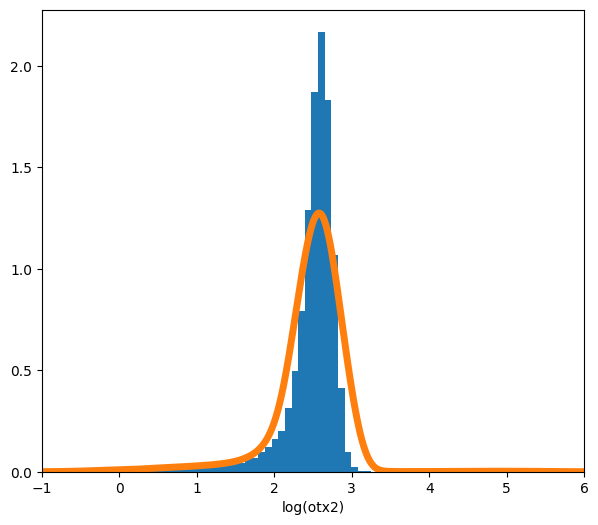

otx2 threshold = 42.948425978763204


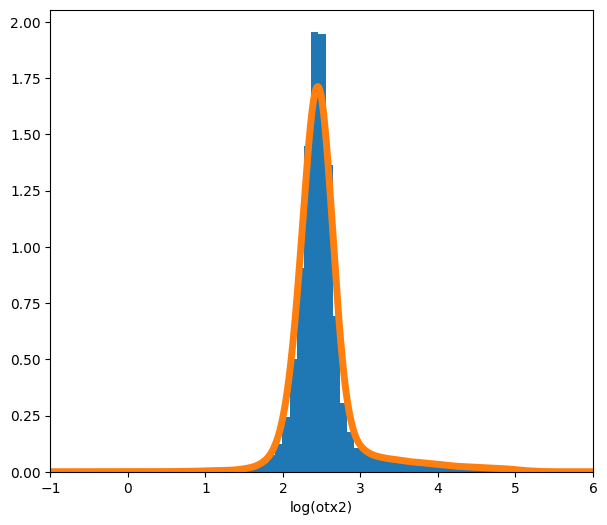

otx2 threshold = 1.5295904196633805


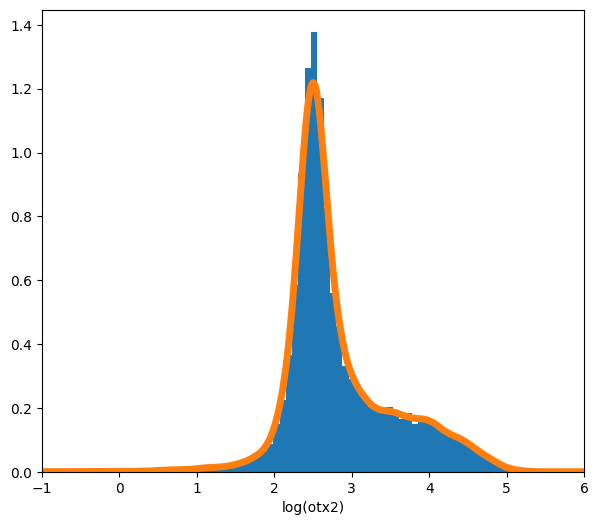

otx2 threshold = 0.7117703227626101


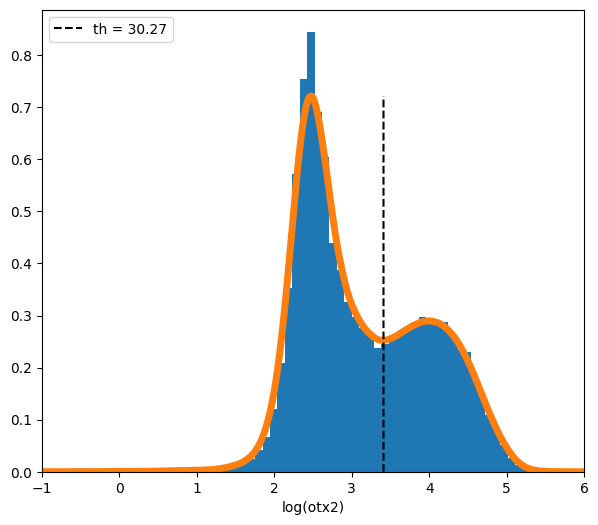

otx2 threshold = 30.265244259400195


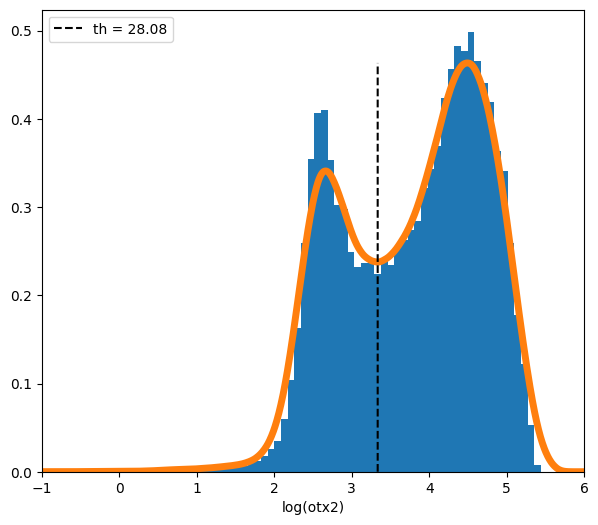

otx2 threshold = 28.07838322380115


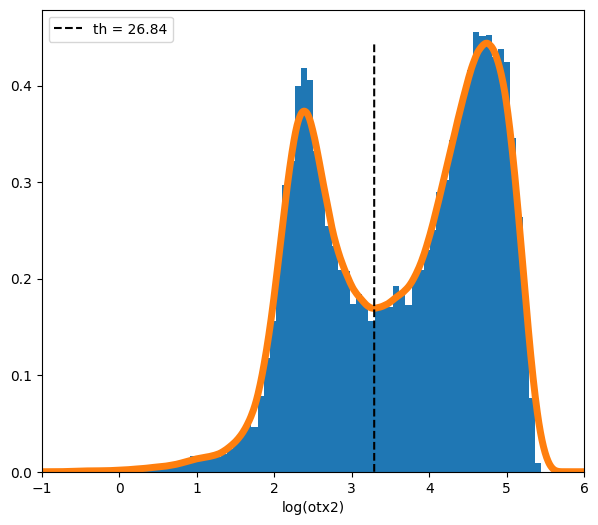

otx2 threshold = 26.84286365589866


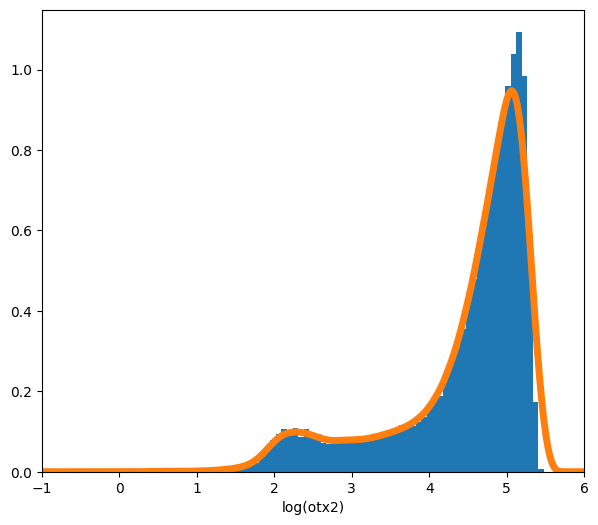

otx2 threshold = 16.038626995655726


In [12]:
otx2_ths = []
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Instantiate KMeans with the number of clusters

from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from scipy.signal import argrelextrema


for c, concentration in enumerate(concentrations):

    otx2 = OTX2[c]
    cer1 = CER1[c]
    X = np.transpose(np.asarray([np.log(otx2), np.log(cer1)]))

    x = np.arange(-1, step=0.005,stop=6.0)
    data = np.log(otx2)
    local_minima=[]
    bw = 0.0
    bw_step = 0.01
    while len(local_minima)!=1:
        bw += bw_step
        modelo_kde = KernelDensity(kernel='linear', bandwidth=bw)
        modelo_kde.fit(X=data.reshape(-1, 1))
        densidad_pred = np.exp(modelo_kde.score_samples(x.reshape((-1,1))))
        local_minima = argrelextrema(densidad_pred, np.less)[0]

    otx2_th = np.exp(x[local_minima[0]])

    fig, ax = plt.subplots(figsize=(7,6))
    ax.hist(data, bins=75, density=True)
    ax.plot(x, densidad_pred, lw=5)
    x_th = np.ones(len(x))*x[local_minima[0]]
    y_th = np.linspace(0, np.max(densidad_pred), num=len(x))
    
    if c in [3,4,5]:
        plt.plot(x_th, y_th, c='k', ls='--', label="th = {:0.2f}".format(otx2_th))
        plt.legend(loc='upper left')
        
    ax.set_xlim(-1,6)
    ax.set_xlabel("log(otx2)")
    plt.savefig(path_save+"otx2-cer1_otx2th_activin-"+concentration+".png")

    plt.show()

    print("otx2 threshold =", otx2_th)
    otx2_ths.append(otx2_th)

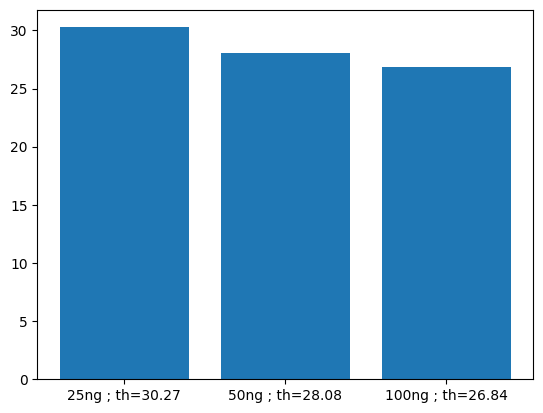

In [13]:
fig, ax = plt.subplots()
x = ["25ng ; th={:0.2f}".format(otx2_ths[3]), "50ng ; th={:0.2f}".format(otx2_ths[4]), "100ng ; th={:0.2f}".format(otx2_ths[5])]
y = [otx2_ths[i] for i in range(3,6)]
ax.bar(x,y)
plt.savefig(path_save+"otx2-cer1_otx2ths_activin.png")
plt.show()

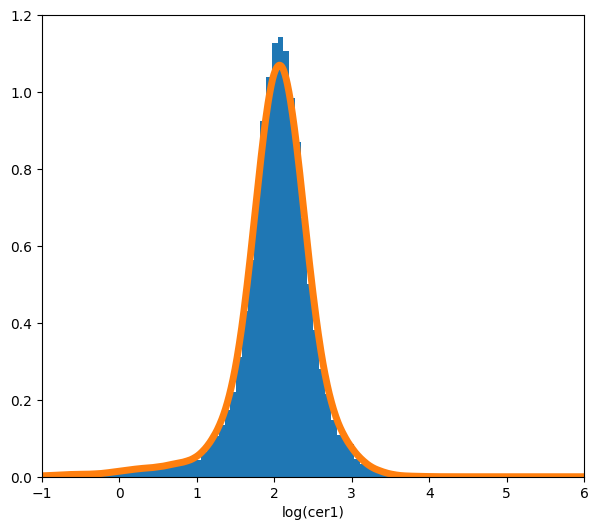

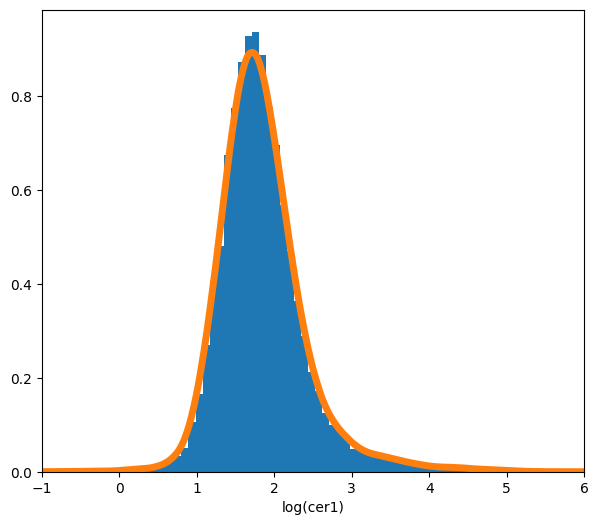

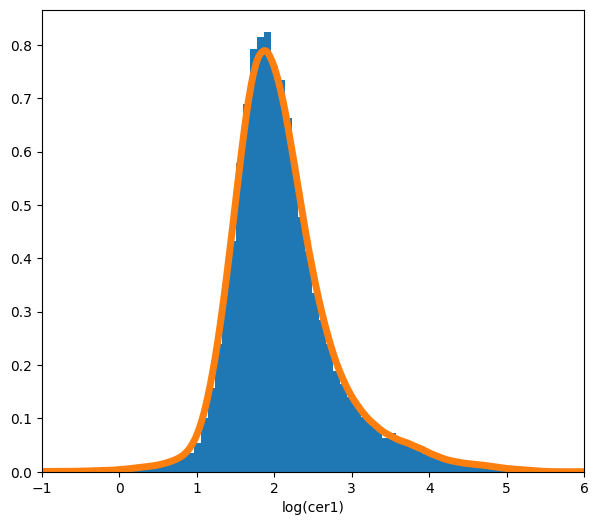

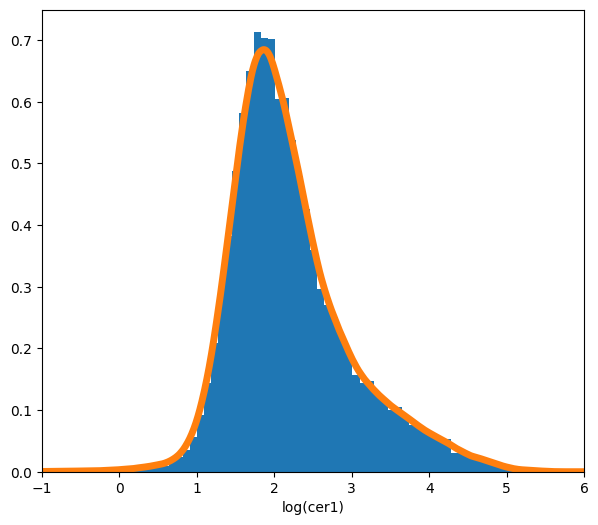

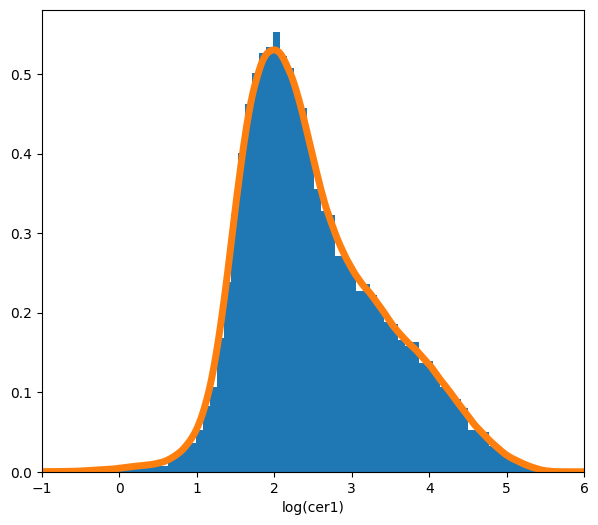

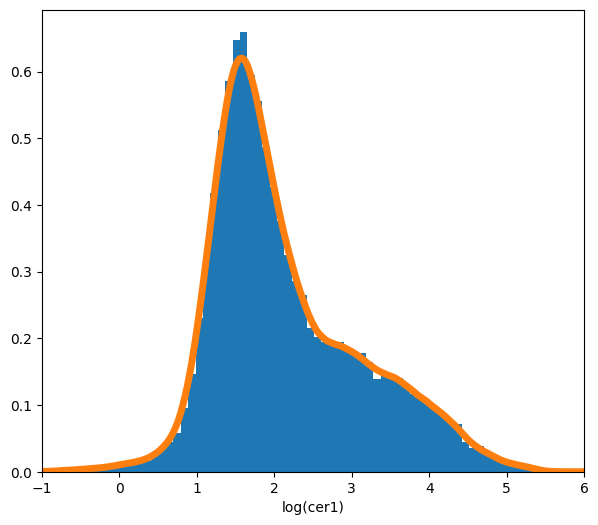

[641 889]
9.070251567856435


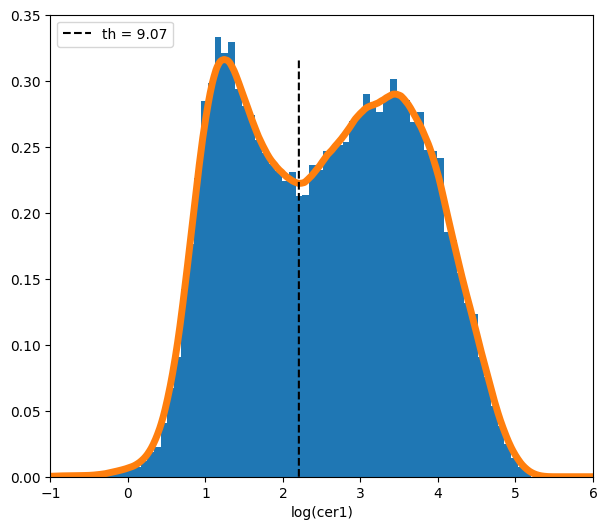

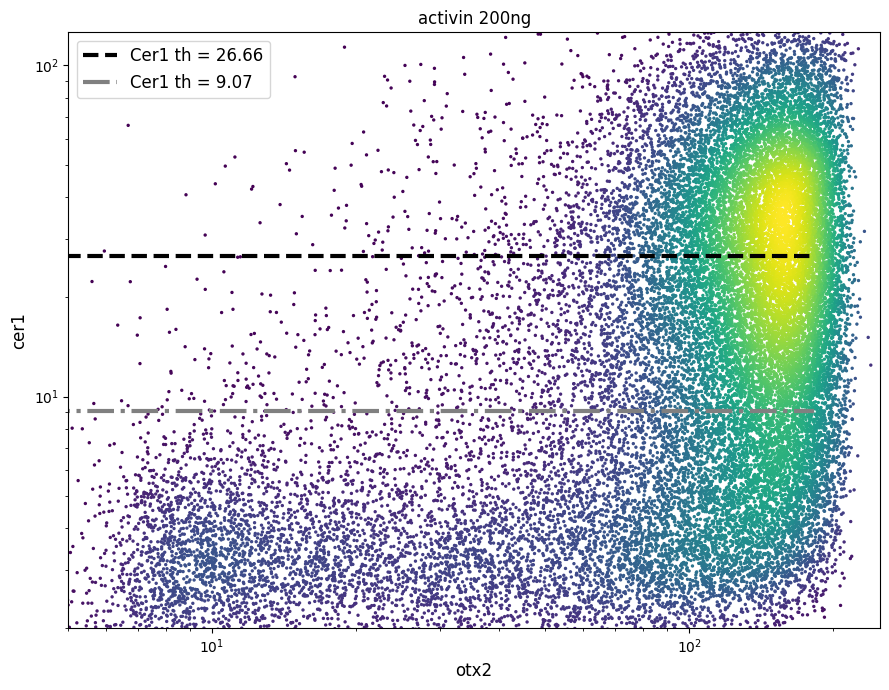

In [32]:
otx2_ths = []
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Instantiate KMeans with the number of clusters

from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from scipy.signal import argrelextrema


for c, concentration in enumerate(concentrations):

    otx2 = OTX2[c]
    cer1 = CER1[c]

    bw = 0.3
    x = np.arange(-1, step=0.005,stop=6.0)
    data = np.log(cer1)
    modelo_kde = KernelDensity(kernel='linear', bandwidth=bw)
    modelo_kde.fit(X=data.reshape(-1, 1))
    densidad_pred = np.exp(modelo_kde.score_samples(x.reshape((-1,1))))
    local_minima = argrelextrema(densidad_pred, np.less)[0]


    fig, ax = plt.subplots(figsize=(7,6))
    ax.hist(data, bins=75, density=True)
    ax.plot(x, densidad_pred, lw=5)
    if c in [6]:
        cer1_th_200 = np.exp(x[local_minima[0]])
        print(local_minima)
        print(cer1_th_200)
        x_th = np.ones(len(x))*x[local_minima[0]]
        y_th = np.linspace(0, np.max(densidad_pred), num=len(x))
        plt.plot(x_th, y_th, c='k', ls='--', label="th = {:0.2f}".format(cer1_th_200))
        plt.legend(loc='upper left')    
    ax.set_xlim(-1,6)
    ax.set_xlabel("log(cer1)")
    plt.savefig(path_save+"otx2-cer1_cer1thdist_activin-"+concentration+".png")
    plt.show()


from scipy.stats import gaussian_kde

# Calculate the point density
otx2cer1 = np.vstack([np.log(otx2),np.log(cer1)])
z_otx2cer1 = gaussian_kde(otx2cer1)(otx2cer1)

fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(otx2, cer1, c=z_otx2cer1, s=2)
# plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("otx2", fontsize=12)
ax.set_ylabel("cer1", fontsize=12)
ax.set_xlim(5, 10**2.4)
ax.set_ylim(2, 10**2.1)
ax.set_title("activin "+concentration)
x = np.linspace(min(cer1), max(cer1), 100)
y = np.ones(len(x)) * cer1_th_0
ax.plot(x, y, c='k', ls='--', lw=3, label="Cer1 th = {:0.2f}".format(cer1_th_0))
y = np.ones(len(x)) * cer1_th_200
ax.plot(x, y, c='grey', ls='-.', lw=3, label="Cer1 th = {:0.2f}".format(cer1_th_200))

plt.tight_layout()
plt.legend(loc='upper left', fontsize=12)
plt.savefig(path_save+"otx2-cer1_cer1th2_activin-"+concentration+".png")
plt.show()

33.363606340819025


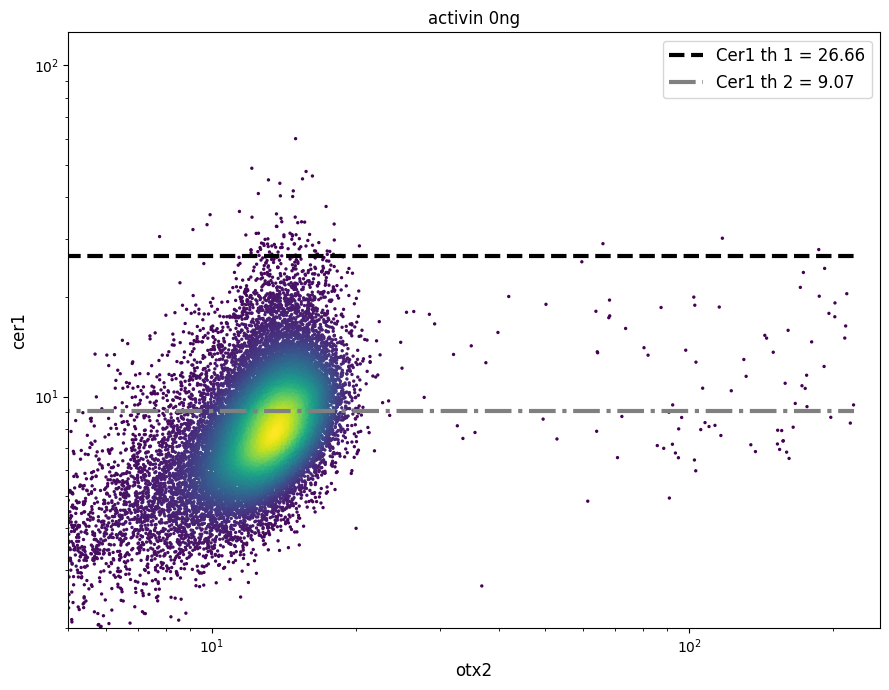

In [30]:
otx2 = OTX2[0]
cer1 = CER1[0]

poscells_cer_200 = [c1 for c1 in cer1 if c1 > cer1_th_200]
print((len(poscells_cer_200)/len(cer1)) * 100)

# Calculate the point density
otx2cer1 = np.vstack([np.log(otx2),np.log(cer1)])
z_otx2cer1 = gaussian_kde(otx2cer1)(otx2cer1)

fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(otx2, cer1, c=z_otx2cer1, s=2)
# plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("otx2", fontsize=12)
ax.set_ylabel("cer1", fontsize=12)
ax.set_xlim(5, 10**2.4)
ax.set_ylim(2, 10**2.1)
ax.set_title("activin "+concentrations[0])
x = np.linspace(min(otx2), max(otx2), 100)
y = np.ones(len(x)) * cer1_th_0
ax.plot(x, y, c='k', ls='--', lw=3, label="Cer1 th 1 = {:0.2f}".format(cer1_th_0))
y = np.ones(len(x)) * cer1_th_200
ax.plot(x, y, c='grey', ls='-.', lw=3, label="Cer1 th 2 = {:0.2f}".format(cer1_th_200))
plt.tight_layout()
plt.legend(loc='upper right', fontsize=12)
plt.savefig(path_save+"otx2-cer1_cer1th_activin-"+concentrations[0]+".png")
plt.show()